# 1.2 - Iterative Gaussianization

In [1]:
!pip install "git+https://github.com/IPL-UV/rbig.git"

  Cloning https://github.com/IPL-UV/rbig.git to /tmp/pip-req-build-gwuvcmry
  Running command git clone -q https://github.com/IPL-UV/rbig.git /tmp/pip-req-build-gwuvcmry
  Resolved https://github.com/IPL-UV/rbig.git to commit bb115eb0720a53721be03087177c1470e831f5ee


In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

## Import Packages

In [3]:
from typing import Union, List

import numpy as np

from sklearn.datasets import make_moons
from scipy import stats
# Packages
import numpy as np
from sklearn.decomposition import PCA
from picard import Picard
import pytorch_lightning as pl


# Plot
import matplotlib.pyplot as plt
import corner

from tqdm.notebook import trange, tqdm 
import wandb
pl.seed_everything(1234)

%load_ext autoreload
%autoreload 2

Global seed set to 1234


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Logging

In [4]:
# TODO

## Data

In [5]:
ntrain = 100_000
nvalid = 5_000
ntest = 10_000
nplot = 1_000_000
noise = 0.1
random_state = 123
train_data = make_moons(n_samples=ntrain, noise=noise, random_state=random_state)[0]
val_data = make_moons(n_samples=nvalid, noise=noise, random_state=random_state)[0]
test_data = make_moons(n_samples=ntest, noise=noise, random_state=random_state*10)[0]
plot_data = make_moons(n_samples=nplot, noise=noise, random_state=random_state*10)[0]

In [6]:
def make_checkerboard(n_samples):
    x1 = np.random.rand(n_samples) * 4 - 2
    x2_ = np.random.rand(n_samples) - np.random.randint(0, 2, [n_samples]) * 2
    x2 = x2_ + np.floor(x1) % 2
    data = np.vstack([x1, x2]).T * 2
    return data

In [7]:
train_data = make_checkerboard(n_samples=ntrain,)
val_data = make_checkerboard(n_samples=nvalid, )
test_data = make_checkerboard(n_samples=ntest, )
plot_data = make_checkerboard(n_samples=nplot, )

In [8]:
train_data.shape

(100000, 2)

### Plot Data

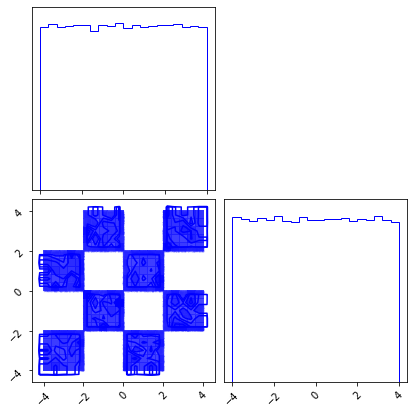

In [9]:
fig = plt.figure(figsize=(7, 7))

corner.corner(train_data, color="blue", fig=fig)

plt.show()

## Flow Transformation

In [11]:
from rbig._src.uniform import MarginalHistogramUniformization, MarginalKDEUniformization
from rbig._src.invcdf import InverseGaussCDF
from rbig._src.base import CompositeBijector

In [13]:
marg_hist_bijector = MarginalHistogramUniformization(X=train_data, bins="sqrt", bound_ext=0.0)
marg_hist_bijector = MarginalKDEUniformization(X=train_data, bound_ext=0.2)

invcdf = InverseGaussCDF(eps=1e-5)


bijectors = [marg_hist_bijector, invcdf]

marg_gauss_bijector = CompositeBijector(bijectors)

X_g = marg_gauss_bijector.forward(train_data)
X_ldj = marg_gauss_bijector.gradient(train_data)

In [14]:
t = np.random.rand(10,2)
t.min(), t.max()

(0.15381230799880152, 0.949722702063876)

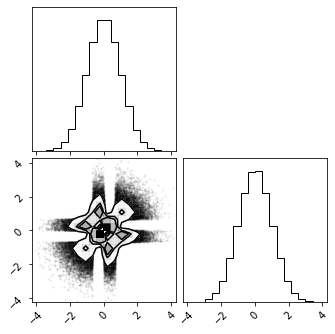

In [15]:
fig = corner.corner(X_g)

## Rotation

In [16]:
from rbig._src.rotation import PCARotation, RandomRotation

In [17]:
pca_bijector = PCARotation(X_g)
randrot_bijector = RandomRotation(X_g)



X_r = randrot_bijector.forward(X_g)

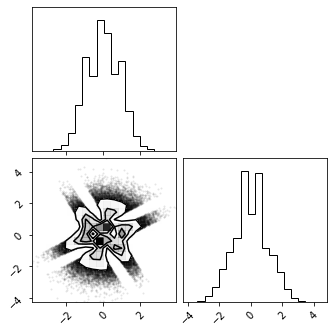

In [18]:
fig = corner.corner(X_r)

In [69]:
# X_g_inv = ica_bijector.forward(X_r)

In [70]:
# fig = corner.corner(X_g_inv)

In [19]:
marg_hist_bijector = MarginalHistogramUniformization(X=train_data)

invcdf = InverseGaussCDF(eps=1e-5)

pca_bijector = RandomRotation(X_g)

bijectors = [marg_hist_bijector, invcdf, pca_bijector]

marg_gauss_bijector = CompositeBijector(bijectors)

X_g = marg_gauss_bijector.forward(train_data)

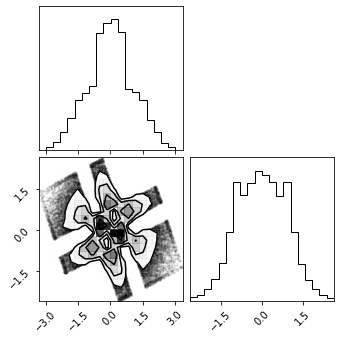

In [20]:
fig = corner.corner(X_g)

## More Transformations

In [23]:
from rbig._src.losses import neg_entropy_normal, negative_log_likelihood

In [24]:
X_train = train_data.copy()
# X_train += 0.1 * np.random.rand(*X_train.shape)
X_valid = val_data.copy()
X_ldj_train = np.zeros(X_train.shape[0])
X_ldj_valid = np.zeros(X_valid.shape[0])

n_layers = 100
alpha = 0.98
transformations = []
train_losses = []
valid_losses = []
with trange(n_layers) as pbar:
    for ilayer in pbar:
    

        # marginal uniformization
        ibijector = MarginalHistogramUniformization(X=X_train, bound_ext=0.3, bins="auto", alpha=1e-10)
#         ibijector = MarginalKDEUniformization(X=X_train, bound_ext=0.3, fft=False, n_quantiles=50, grid_size=100)
        transformations.append(ibijector)
        # train data
        X_ldj_train += ibijector.gradient(X_train)
        X_train = ibijector.forward(X_train)
        # valid data
        X_ldj_valid += ibijector.gradient(X_valid)
        X_valid = ibijector.forward(X_valid)

        

        # inverse cdf transformation
        ibijector = InverseGaussCDF(1e-7)
        # save bijector
        transformations.append(ibijector)
        # train data
        X_ldj_train += ibijector.gradient(X_train)
        X_train = ibijector.forward(X_train)
        # valid data
        X_ldj_valid += ibijector.gradient(X_valid)
        X_valid = ibijector.forward(X_valid)

        # rotation
        ibijector = PCARotation(X=X_train)
        # save bijector
        transformations.append(ibijector)
        # train data
        X_ldj_train += ibijector.gradient(X_train)
        X_train = ibijector.forward(X_train)
        # valid data
        X_ldj_valid += ibijector.gradient(X_valid)
        X_valid = ibijector.forward(X_valid)

#         if (ilayer+1) % 5 == 0:
#             fig = corner.corner(X)
            
        # calculate the loss
        loss_train = negative_log_likelihood(X_train, X_ldj_train)
        loss_valid = negative_log_likelihood(X_valid, X_ldj_valid)
        k2, p = stats.normaltest(X_valid, axis=None)
        neg_ent = neg_entropy_normal(X_valid)
        

        
        
            
        pbar.set_description(f"Loss (Train): {loss_train:.4f} | Loss (Valid): {loss_valid:.4f} | NormTest: {p:.2e} | KL Normal: {neg_ent.sum():.5f}")
        
        train_losses.append(loss_train)
        valid_losses.append(loss_valid)

        

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
k2, p = stats.normaltest(X_valid, axis=None)
neg_ent = neg_entropy_normal(X_valid)
k2, p, neg_ent.sum()

(0.8900466592917546, 0.6408093260032797, 0.003495116498621587)

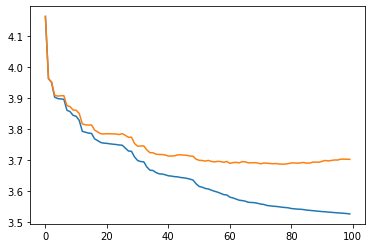

In [26]:
fig, ax = plt.subplots()
ax.plot(train_losses)
ax.plot(valid_losses)
plt.show()

In [27]:
from rbig._src.base import FlowModel

In [28]:
# init base distribution
base_dist = stats.multivariate_normal(mean=np.zeros(2), cov=np.ones(2))

# init flow model
gf_model = FlowModel(transformations, base_dist)

In [30]:
# score test samples
gf_model.score_samples(test_data)

/datadrive/eman/miniconda3/envs/gaussflow-gpu/lib/python3.8/site-packages/rbig/_src/base.py:73: RuntimeWarning: divide by zero encountered in log
  return -np.mean(np.log(prob))


inf

## Forward Transformation

In [31]:
X_g = gf_model.forward(train_data)

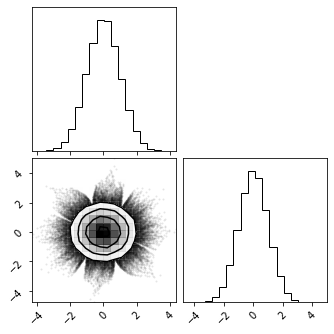

In [32]:
fig = corner.corner(X_g)

### Inverse Transform

In [33]:
X_approx = gf_model.inverse(X_g)

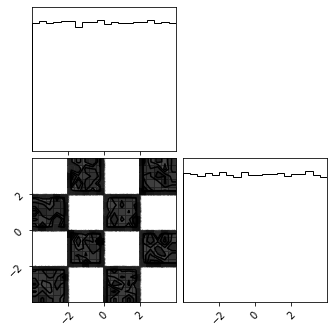

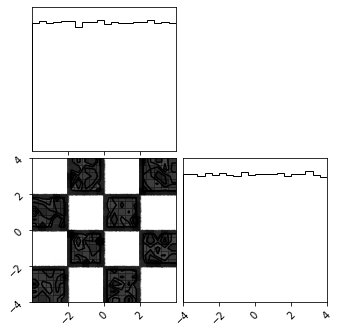

In [34]:
fig = corner.corner(train_data)
fig = corner.corner(X_approx)

## Density Estimation

In [35]:
n_grid = 200
buffer = 0.01
xline = np.linspace(test_data[:, 0].min() - buffer, train_data[:, 0].max() + buffer, n_grid)
yline = np.linspace(test_data[:, 1].min() - buffer, train_data[:, 1].max() + buffer, n_grid)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

In [36]:
X_prob = gf_model.predict_proba(xyinput)

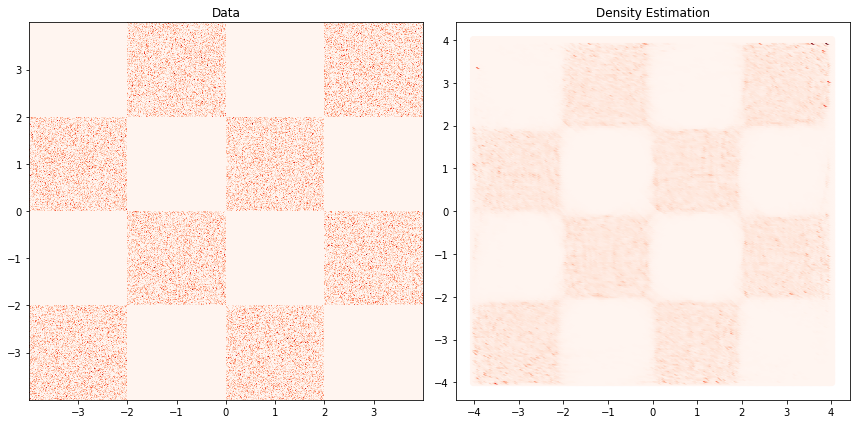

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('Data')
ax[0].hist2d(train_data[...,0], train_data[...,1], cmap="Reds", bins=512, density=True)
# ax[0].set_xlim([-4, 4]); ax[0].set_ylim([-4, 4]); ax[0].axis('off')
ax[1].set_title('Density Estimation')
ax[1].scatter(xyinput[...,0], xyinput[...,1], c=X_prob, cmap="Reds",)
# ax[1].set_xlim([-4, 4]); ax[1].set_ylim([-4, 4]); ax[1].axis('off')
plt.tight_layout()
plt.show()

## Sampling

In [38]:
%%time

X_samples = gf_model.sample(200_000)

CPU times: user 1min 3s, sys: 3.25 s, total: 1min 6s
Wall time: 5.62 s


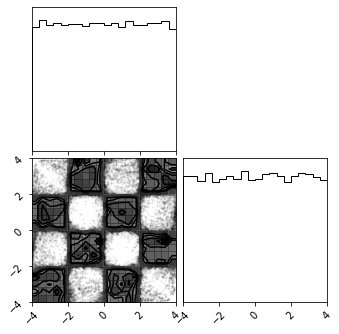

In [39]:
fig = corner.corner(X_samples)